In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/Sirius/
%ls

/content/drive/MyDrive/Sirius
comments.txt  model.py      requirements.txt  stage2_1.ipynb  Untitled0.ipynb
dev_dataset/  ood_samples/  stage1_1.ipynb    stage2.ipynb    utils.py
id_samples/   __pycache__/  stage1.ipynb      test.ipynb      weights.h5


# Методы для получения OOD данных
Так как известно, что модель плохо работает на данных плохого качества, то можно сгенерировать зашумленные данные в качестве OOD данных.
Для генерации данных использовалось ухудшение качесва, добавление гауссовского шума и атака изображений(для усиления разброса данных).
Для того, чтобы определить на сколько сильно полученные данные далеки от ID данных, используется mahalanobis distance, которая показывает расстояние элемента данных от распределения данных, а также евклидова норма.

# Импорт бибилиотек и инициализация некоторых переменных

In [3]:
from model import InceptionResNetV1
import utils
import cv2
from matplotlib import pyplot as plt
from pathlib import Path
import os
import random
import pandas as pd
import numpy as np
import tensorflow as tf
from tqdm import tqdm
import tensorflow_datasets as tfds

from sklearn.decomposition import PCA

In [4]:
id_path = './id_samples'
ood_path = './ood_samples'
id_samples_dir = os.listdir(id_path)
target_size = (160, 160)

In [5]:
model = utils.face_model

# Подсчет всех эмбедингов на ID данных
Используется функция get_embeddings, которая добавляет в заданный DataFrame название картинки и её эмбединг.

In [6]:
def get_embeddings(model, id_samples_dir, path='./id_samples', target_size=(160, 160)):
  df = pd.DataFrame(columns=['name', 'embedding'])
  for im_name in tqdm(id_samples_dir, total=len(id_samples_dir)):
    im = cv2.imread(f'{path}/{im_name}')
    # print(f'{path}/{im_name}')
    im = im[..., ::-1]
    im = utils.__resize(im, target_size)
    output = model(im, training=False).numpy()
    df.loc[len(df)] = {'name': im_name, 'embedding': output}
  return df

In [7]:
df_embeddings = get_embeddings(model, id_samples_dir, path=id_path, target_size=target_size)
df_embeddings.sample(3)

100%|██████████| 1477/1477 [24:28<00:00,  1.01it/s]


,name,embedding
274,Chadha_Gurinder_3.jpg,"[[-0.28221875, -0.882107, 0.40875292, -0.44375..."
1149,Bill_Richardson_3.jpg,"[[0.0072234124, -0.32053548, -0.6872524, -0.73..."
46,Guillaume_Soro_3.jpg,"[[-0.4903271, -0.29174712, -0.7012072, -0.4478..."


In [8]:
embeddings = np.vstack(df_embeddings['embedding'].values)
embeddings.shape

(1477, 128)

# Метод отбора данных для OOD датасета
Для того, чтобы определить являются ли входные данные выбросами из распределения, используется Mahalanobis distance и евклидова норма.<br>
<br>
Сначала необходимо определить трешолды для Mahalanobis distance и евклидовой нормы, поэтому они подсчитываются для всех выходных векторов, и составляются графики с их значениями.

In [9]:
mean = np.mean(embeddings, axis=0) # считается среднее для эмбедингов
cov = np.cov(embeddings.T) # считается ковариационная матрица по матрице эмбедингов

In [10]:
def mahalonis_distance(x, mean, cov):
  diff = x - mean
  mahal = np.sqrt(diff.T @ cov @ diff)
  return mahal

In [14]:
df_embeddings['mahalonis'] = df_embeddings['embedding'].apply(lambda x: mahalonis_distance(x[0], mean, cov))
df_embeddings['norm'] = df_embeddings['embedding'].apply(lambda x: np.linalg.norm(x))
df_embeddings.sample(3)

,name,embedding,mahalonis,norm
1306,Horst_Koehler_1.jpg,"[[-0.08780216, -0.25051633, -0.40093285, -0.34...",3.169767,4.782449
1214,Barbara_Walters_3.jpg,"[[-0.6610663, -0.4814537, -0.20209855, -0.4189...",6.017530,5.655108
777,Edmund_Stoiber_1.jpg,"[[0.7003064, 0.5623064, 0.36880785, -1.5232929...",11.608462,11.509442


In [31]:
treshold_mahalonis  = np.percentile(df_embeddings['mahalonis'].values, q=96)
treshold_norm       = np.percentile(df_embeddings['norm'].values, q=94)

Исходя из графиков в качестве порогов выбрал 96-ую и 94-ую процентили

Text(0.5, 1.0, 'norm')

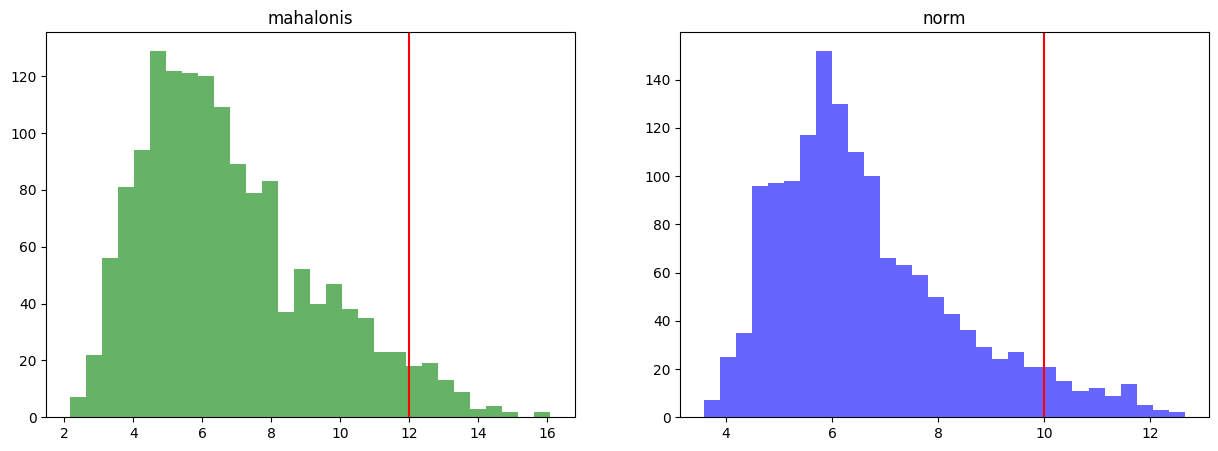

In [32]:
fig, ax = plt.subplots(1, 2, figsize=(15,5))
ax[0].hist(df_embeddings['mahalonis'], color='green', alpha=0.6, bins=30)
ax[0].axvline(x=treshold_mahalonis, color='r')
ax[1].hist(df_embeddings['norm'], color='blue', alpha=0.6, bins=30)
ax[1].axvline(x=treshold_norm, color='r')
ax[0].set_title('mahalonis')
ax[1].set_title('norm')

In [43]:
def perturb_image(img_resized, model, eps=0.07):
  '''Атака на изображение в направлении градиента по евклидовой норме'''
  img = img_resized
  input_tensor = tf.convert_to_tensor(img, dtype=tf.float64)
  # input_tensor = tf.expand_dims(input_tensor, axis=0)
  with tf.GradientTape() as tape:
    tape.watch(input_tensor)
    emb = model(input_tensor, training=False)
    distance = tf.norm(emb)
  gradient = tape.gradient(distance, input_tensor)
  gradient_sign = tf.sign(gradient)
  perturbed_tensor = input_tensor + eps*gradient_sign
  # perturbed = tf.squeeze(perturbed_tensor)
  perturbed = np.clip(perturbed_tensor.numpy(), 0.0, 1.0)
  return perturbed

In [34]:
def downgrade_quality(image, factor=(0.3, 0.3)):
  '''Снижение качества изображение с помощью resize'''
  h,w,_ = image.shape
  new_h, new_w = int(h*factor[0]), int(w*factor[1])
  im = cv2.resize(image, (new_h, new_w))
  im = cv2.resize(im, (h, w))
  return im

In [36]:
def make_noise(image, eps=0.07):
  '''Добавление гауссовского шума'''
  im = np.clip((image/255 + np.random.randn(*image.shape)*eps)*255, 0, 255)
  im = im.astype(np.uint8)
  return im

In [37]:
def save_image(image, directory, name):
  image = image[..., ::-1]
  assert cv2.imwrite(f'{directory}/{name}', image)

In [38]:
def load_image(directory, name):
  image = cv2.imread(f'{directory}/{name}')
  image = image[..., ::-1]
  return image

### Подсчет значений mahalanobis distance и нормы для изображений с ухудшенным качеством и гауссовским шумом

In [40]:
df_noisy_images = pd.DataFrame(columns=['name', 'image', 'embedding', 'mahalonis', 'norm'])
# id_samples_dir
for im_name in tqdm(id_samples_dir, total=len(id_samples_dir)):
  image = load_image(id_path, im_name)
  image = downgrade_quality(image)
  image = make_noise(image)
  image_name = f'quality_noise_{im_name}'
  im = utils.__resize(image, target_size)
  emb = model(im, training=False).numpy()
  mahalonis = mahalonis_distance(emb[0], mean, cov)
  norm = np.linalg.norm(emb)
  df_noisy_images.loc[len(df_noisy_images)] = {'name': image_name, 'image': image, 'embedding': emb, 'mahalonis': mahalonis, 'norm': norm}

100%|██████████| 1477/1477 [18:12<00:00,  1.35it/s]


Подсчет значений mahalanobis distance и нормы для проатакованных изображений

In [44]:
df_pert_images = pd.DataFrame(columns=['name', 'image', 'embedding', 'mahalonis', 'norm'])
# id_samples_dir
for im_name in tqdm(id_samples_dir, total=len(id_samples_dir)):
  image = load_image(id_path, im_name)
  image_name = f'pert_{im_name}'
  im = utils.__resize(image, target_size)
  perturbed_image = perturb_image(im, model)
  emb = model(perturbed_image, training=False).numpy()
  perturbed_image = np.clip(perturbed_image*255, 0, 255).astype(np.uint8)[0]
  mahalonis = mahalonis_distance(emb[0], mean, cov)
  norm = np.linalg.norm(emb)
  df_pert_images.loc[len(df_pert_images)] = {'name': image_name, 'image': perturbed_image, 'embedding': emb, 'mahalonis': mahalonis, 'norm': norm}

100%|██████████| 1477/1477 [48:57<00:00,  1.99s/it]


In [45]:
df_noisy_images.sample(3)

,name,image,embedding,mahalonis,norm
1029,quality_noise_Elena_Bovina_1.jpg,"[[[12, 19, 24], [49, 66, 61], [24, 27, 40], [2...","[[-0.104933515, -0.32578266, -1.0357114, -0.56...",5.417044,6.517382
1074,quality_noise_Mark_Geragos_2.jpg,"[[[0, 0, 26], [0, 20, 0], [0, 0, 0], [20, 26, ...","[[-0.2460055, -0.66780734, -0.2586277, -0.5650...",3.781777,4.897503
1237,quality_noise_Larry_Nichols_2.jpg,"[[[163, 197, 184], [180, 195, 225], [167, 213,...","[[0.2764514, -0.23557235, -0.31016976, -0.7538...",3.974687,5.585745


In [46]:
df_pert_images.sample(3)

,name,image,embedding,mahalonis,norm
703,pert_Scott_McNealy_1.jpg,"[[[17, 17, 0], [17, 17, 17], [0, 0, 17], [0, 0...","[[-0.28414974, -0.46413258, 0.62552714, 0.7534...",10.228467,9.507666
68,pert_Eddie_Fenech_Adami_3.jpg,"[[[17, 17, 17], [17, 17, 17], [0, 0, 0], [17, ...","[[-0.29450676, -0.14958075, -0.8714618, 0.3323...",9.568757,8.209352
869,pert_Arnold_Palmer_1.jpg,"[[[0, 0, 0], [0, 17, 17], [0, 17, 17], [0, 0, ...","[[-0.21816772, -0.73646045, -0.5592565, -0.353...",10.152069,7.977584


Сохраняю изображения с ухудшенным качетвом и шумом, если какая-либо из метрик превосходит выбранные пороги

In [48]:
names = df_noisy_images[(df_noisy_images['mahalonis'] > treshold_mahalonis)|(df_noisy_images['norm'] > treshold_norm)]['name'].values
for name in tqdm(names, total=len(names)):
  im = df_noisy_images[df_noisy_images['name']==name]['image'].values[0]
  save_image(im, ood_path, name)

100%|██████████| 63/63 [00:01<00:00, 62.41it/s]


Сохраняю проатакованные изображения, если какая-либо из метрик превосходит выбранные пороги

In [49]:
names = df_pert_images[(df_pert_images['mahalonis'] > treshold_mahalonis)|(df_pert_images['norm'] > treshold_norm)]['name'].values
for name in tqdm(names, total=len(names)):
  im = df_pert_images[df_pert_images['name']==name]['image'].values[0]
  save_image(im, ood_path, name)

100%|██████████| 565/565 [00:07<00:00, 73.99it/s]


# Для визуализации распределений данных подсчитываются отображения эмбедингов на двумерное пространство с помощью метода PCA

In [51]:
ood_samples = os.listdir(ood_path)
df_ood_embeddings = get_embeddings(model, ood_samples, ood_path, target_size)
df_ood_embeddings.sample(3)

100%|██████████| 628/628 [08:44<00:00,  1.20it/s]


,name,embedding
257,pert_Mario_Jardel_1.jpg,"[[-0.49417892, 1.4584783, -0.29609263, -0.0145..."
269,pert_Sam_Brownback_2.jpg,"[[0.28101015, -0.16616064, -0.4770547, -0.2517..."
237,pert_Jean_Carnahan_1.jpg,"[[-1.2579943, 0.18125784, 0.057561852, -0.1667..."


In [52]:
ood_embeddings = np.vstack(df_ood_embeddings['embedding'].values)
ood_embeddings.shape

(628, 128)

In [53]:
id_pca = PCA(n_components=2)
id_reduced_emb = id_pca.fit_transform(embeddings)
ood_pca = PCA(n_components=2)
ood_reduced_emb = ood_pca.fit_transform(ood_embeddings)

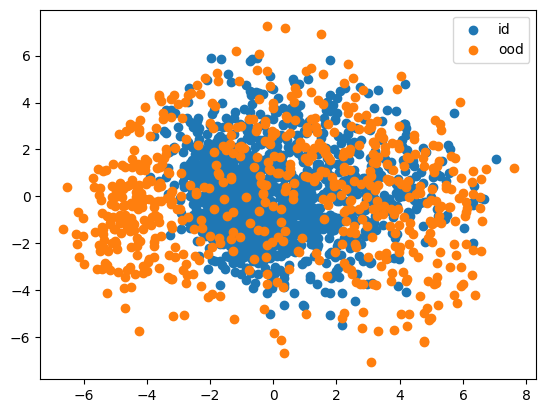

In [60]:
plt.scatter(id_reduced_emb[:,0], id_reduced_emb[:,1], label='id')
plt.scatter(ood_reduced_emb[:,0], ood_reduced_emb[:,1], label='ood')
plt.legend()
plt.show()